In [1]:
import os
import numpy as np
import pandas as pd
import swifter
import warnings
from loguru import logger

from exonamd.catalog import download_nasa_confirmed_planets
from exonamd.utils import ROOT
from exonamd.utils import fetch_aliases
from exonamd.utils import update_host
from exonamd.utils import update_planet
from exonamd.utils import check_name
from exonamd.solve import solve_values
from exonamd.interp import interp_eccentricity
from exonamd.interp import interp_mass
from exonamd.interp import interp_inclination
from exonamd.interp import interp_sma
from exonamd.solve import solve_relincl
from exonamd.interp import interp_trueobliq
from exonamd.utils import groupby_apply_merge
from exonamd.solve import solve_namd
from exonamd.solve import solve_namd_mc
from exonamd.plot import plot_host_namd
from exonamd.plot import pop_plot


warnings.filterwarnings("ignore")
pd.options.display.max_columns = 20
pd.options.display.max_rows = 30
pd.options.mode.copy_on_write = True
swifter.set_defaults(
    npartitions=None,
    dask_threshold=1,
    scheduler="processes",
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=False,
    force_parallel=False,
)

In [2]:
# fetch_aliases(["Kepler-90"])

In [3]:
%load_ext autoreload
%autoreload 2

In [7]:
fname = "custom_db_20241017e"

df = pd.read_csv(
    os.path.join('../exonamd', "data", f"{fname}.csv"),
)

### Task 3: computing missing values (if any) from simple relations


In [8]:
logger.info("Computing missing values from simple relations")
df[
    [
        "pl_orbsmax",
        "pl_ratdor",
        "st_rad",
        "pl_rade",
        "pl_ratror",
        "pl_orbper",
        "st_mass",
    ]
] = df.swifter.apply(solve_values, axis=1)
logger.info("Missing values computed")

2025-07-08 16:22:10.591 | INFO     | __main__:<module>:1 - Computing missing values from simple relations


Pandas Apply:   0%|          | 0/24 [00:00<?, ?it/s]

2025-07-08 16:22:10.642 | INFO     | __main__:<module>:13 - Missing values computed


### Task 4: storing the curated database


Drop columns that are no longer needed


In [9]:
logger.debug("Dropping columns that are no longer needed")
df.drop(
    columns=[
        "pl_ratdor",
        "st_rad",
        "pl_ratror",
        "pl_orbper",
        "st_mass",
    ],
    inplace=True,
)
logger.debug("Columns dropped")

2025-07-08 16:22:11.561 | DEBUG    | __main__:<module>:1 - Dropping columns that are no longer needed
2025-07-08 16:22:11.564 | DEBUG    | __main__:<module>:12 - Columns dropped


In [10]:
logger.info("Storing the curated database")

out_path = os.path.join(ROOT, "data", f"exo_{fname}.csv")
df.to_csv(out_path, index=False)
logger.info(f"Database stored at {out_path}")

2025-07-08 16:22:22.184 | INFO     | __main__:<module>:1 - Storing the curated database
2025-07-08 16:22:22.202 | INFO     | __main__:<module>:5 - Database stored at /export/NAS/ariel/data/andrea.bocchieri/ExoNAMD/exonamd/data/exo_custom_db_20241017e.csv


### Task 5: input missing values (if any) by interpolation


Use nanmedian to thin down the data


In [11]:
logger.info("Thinning down the data with nanmedian")
cols = df.columns.difference(["hostname", "pl_name", "default_flag", "rowupdate"])
medians = df.groupby("pl_name")[cols].transform(np.nanmedian)
df.loc[df["default_flag"] == 1, cols] = medians.loc[df["default_flag"] == 1]
df = df[df["default_flag"] == 1].drop(columns="default_flag")
logger.info("Data thinned down")

2025-07-08 16:22:48.281 | INFO     | __main__:<module>:1 - Thinning down the data with nanmedian
2025-07-08 16:22:48.317 | INFO     | __main__:<module>:6 - Data thinned down


Check presence of duplicates (if any)


In [12]:
logger.info("Checking for duplicates")
dp = df[df.duplicated(subset=["hostname", "pl_name"], keep=False)].sort_values(
    by=["hostname", "pl_name"]
)

if len(dp) > 0:
    logger.error(f"Duplicated rows for {dp['hostname'].unique()}")
    raise ValueError(f"Duplicated rows for {dp['hostname'].unique()}")
logger.info("No duplicates found")

2025-07-08 16:22:51.887 | INFO     | __main__:<module>:1 - Checking for duplicates
2025-07-08 16:22:51.893 | INFO     | __main__:<module>:9 - No duplicates found


Instantiate flags


In [13]:
logger.info("Instantiating the flags")
df["flag"] = "0"
logger.info("Flags instantiated")

2025-07-08 16:22:56.189 | INFO     | __main__:<module>:1 - Instantiating the flags
2025-07-08 16:22:56.192 | INFO     | __main__:<module>:3 - Flags instantiated


Solve missing eccentricity values


In [14]:
logger.info("Interpolating missing eccentricity values")
df[
    [
        "pl_orbeccen",
        "pl_orbeccenerr1",
        "pl_orbeccenerr2",
        "flag",
    ]
] = df.swifter.apply(interp_eccentricity, axis=1)
logger.info("Values interpolated")

2025-07-08 16:22:58.311 | INFO     | __main__:<module>:1 - Interpolating missing eccentricity values


Pandas Apply:   0%|          | 0/24 [00:00<?, ?it/s]

2025-07-08 16:22:58.345 | INFO     | __main__:<module>:10 - Values interpolated


Solve missing planetary mass values


In [15]:
logger.info("Interpolating missing planetary mass values")
df[
    [
        "pl_bmasse",
        "pl_bmasseerr1",
        "pl_bmasseerr2",
        "flag",
    ]
] = df.swifter.apply(interp_mass, axis=1)
logger.info("Values interpolated")

2025-07-08 16:23:00.578 | INFO     | __main__:<module>:1 - Interpolating missing planetary mass values


Pandas Apply:   0%|          | 0/24 [00:00<?, ?it/s]

2025-07-08 16:23:00.614 | INFO     | __main__:<module>:10 - Values interpolated


Drop columns that are no longer needed


In [16]:
logger.debug("Dropping columns that are no longer needed")
df.drop(columns=["pl_rade", "pl_radeerr1", "pl_radeerr2"], inplace=True)
logger.debug("Columns dropped")

2025-07-08 16:23:05.170 | DEBUG    | __main__:<module>:1 - Dropping columns that are no longer needed
2025-07-08 16:23:05.173 | DEBUG    | __main__:<module>:3 - Columns dropped


Remove systems where at least one planet has no mass or semi-major axis (if any)


In [17]:
logger.info("Removing systems where at least one planet has no mass or semi-major axis")
mask = (
    df.groupby("hostname")[["pl_bmasse", "pl_orbsmax"]]
    .transform(lambda x: x.isnull().any())
    .any(axis=1)
)
rm_systems = df[mask]["hostname"].unique()
logger.info(f"Removing {len(rm_systems)} systems: {rm_systems}")
df = df[~mask]
logger.info("Systems removed")

2025-07-08 16:23:07.799 | INFO     | __main__:<module>:1 - Removing systems where at least one planet has no mass or semi-major axis
2025-07-08 16:23:07.808 | INFO     | __main__:<module>:8 - Removing 0 systems: []
2025-07-08 16:23:07.810 | INFO     | __main__:<module>:10 - Systems removed


Solve missing values in inclinations


In [18]:
logger.info("Interpolating missing values in inclinations")
df[
    [
        "pl_orbincl",
        "pl_orbinclerr1",
        "pl_orbinclerr2",
        "flag",
    ]
] = df.swifter.apply(interp_inclination, args=(df,), axis=1)
logger.info("Values interpolated")

2025-07-08 16:23:11.412 | INFO     | __main__:<module>:1 - Interpolating missing values in inclinations


Pandas Apply:   0%|          | 0/24 [00:00<?, ?it/s]

2025-07-08 16:23:11.475 | INFO     | __main__:<module>:10 - Values interpolated


Interpolate missing values in semi-major axis uncertainties


In [19]:
logger.info("Interpolating missing values in semi-major axis uncertainties")
df[
    [
        "pl_orbsmaxerr1",
        "pl_orbsmaxerr2",
        "flag",
    ]
] = df.swifter.apply(interp_sma, axis=1)
logger.info("Values interpolated")

2025-07-08 16:23:15.533 | INFO     | __main__:<module>:1 - Interpolating missing values in semi-major axis uncertainties


Pandas Apply:   0%|          | 0/24 [00:00<?, ?it/s]

2025-07-08 16:23:15.567 | INFO     | __main__:<module>:9 - Values interpolated


### Task 6: compute the parameters for the NAMD calculation


Compute the relative inclination


In [20]:
logger.info("Computing the relative inclinations")
df[
    [
        "pl_relincl",
        "pl_relinclerr1",
        "pl_relinclerr2",
    ]
] = df.swifter.apply(solve_relincl, args=(df,), axis=1)
logger.info("Values computed")

2025-07-08 16:23:22.955 | INFO     | __main__:<module>:1 - Computing the relative inclinations


Pandas Apply:   0%|          | 0/24 [00:00<?, ?it/s]

2025-07-08 16:23:23.029 | INFO     | __main__:<module>:9 - Values computed


Interpolate missing values in true obliquity


In [21]:
logger.info("Interpolating missing values in true obliquity")
df[
    [
        "pl_trueobliq",
        "pl_trueobliqerr1",
        "pl_trueobliqerr2",
        "flag",
    ]
] = df.swifter.apply(interp_trueobliq, args=(df,), axis=1)
logger.info("Values interpolated")

2025-07-08 16:23:27.404 | INFO     | __main__:<module>:1 - Interpolating missing values in true obliquity


Pandas Apply:   0%|          | 0/24 [00:00<?, ?it/s]

2025-07-08 16:23:27.479 | INFO     | __main__:<module>:10 - Values interpolated


### Task 7: storing the curated+interpolated database


In [22]:
logger.info("Storing the curated+interpolated database")
out_path = os.path.join(ROOT, "data", f"exo_interp_{fname}.csv")
df.to_csv(out_path, index=False)
logger.info(f"Database stored at {out_path}")

2025-07-08 16:23:39.534 | INFO     | __main__:<module>:1 - Storing the curated+interpolated database
2025-07-08 16:23:39.542 | INFO     | __main__:<module>:4 - Database stored at /export/NAS/ariel/data/andrea.bocchieri/ExoNAMD/exonamd/data/exo_interp_custom_db_20241017e.csv


In [23]:
df = pd.read_csv(os.path.join(ROOT, "data", f"exo_interp_{fname}.csv"))

### Task 8: computing the NAMD


Drop columns that are no longer needed

In [24]:
logger.debug("Dropping columns that are no longer needed")
df.drop(columns=["pl_orbincl", "pl_orbinclerr1", "pl_orbinclerr2"], inplace=True)
logger.debug("Columns dropped")

2025-07-08 16:23:55.421 | DEBUG    | __main__:<module>:1 - Dropping columns that are no longer needed
2025-07-08 16:23:55.424 | DEBUG    | __main__:<module>:3 - Columns dropped


Solve the relative and absolute namd


In [25]:
logger.info("Computing the relative NAMD")
df = groupby_apply_merge(
    df,
    "hostname",
    solve_namd,
    kind="rel",
    allow_overwrite=True,
)
logger.info("Relative NAMD computed")

2025-07-08 16:23:57.442 | INFO     | __main__:<module>:1 - Computing the relative NAMD
2025-07-08 16:23:57.485 | INFO     | __main__:<module>:9 - Relative NAMD computed


In [26]:
logger.info("Computing the absolute NAMD")
df = groupby_apply_merge(
    df,
    "hostname",
    solve_namd,
    kind="abs",
    allow_overwrite=True,
)
logger.info("Absolute NAMD computed")

2025-07-08 16:24:00.691 | INFO     | __main__:<module>:1 - Computing the absolute NAMD
2025-07-08 16:24:00.712 | INFO     | __main__:<module>:9 - Absolute NAMD computed


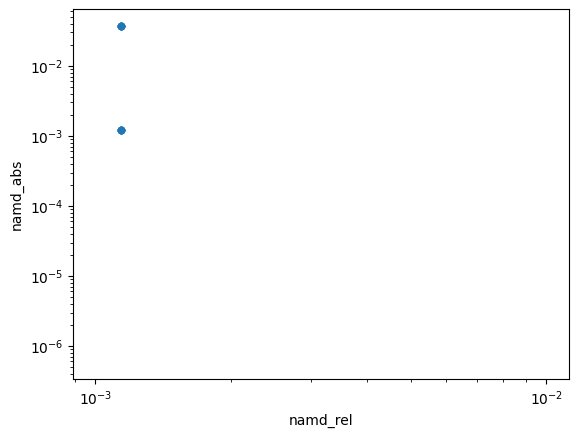

In [27]:
_ = (
    df.groupby("hostname")[["namd_rel", "namd_abs"]]
    .transform("mean")
    .plot(kind="scatter", x="namd_rel", y="namd_abs", loglog=True)
)

In [41]:
df[["namd_rel", "namd_abs"]]

,namd_rel,namd_abs
0,0.001142,1.202155e-03
1,0.001142,1.202155e-03
2,0.001142,1.202155e-03
3,0.001142,1.202155e-03
4,0.001142,1.202155e-03
5,0.001142,1.202155e-03
6,0.001142,1.202155e-03
7,0.001142,1.202155e-03
8,0.001142,3.690002e-02
9,0.001142,3.690002e-02


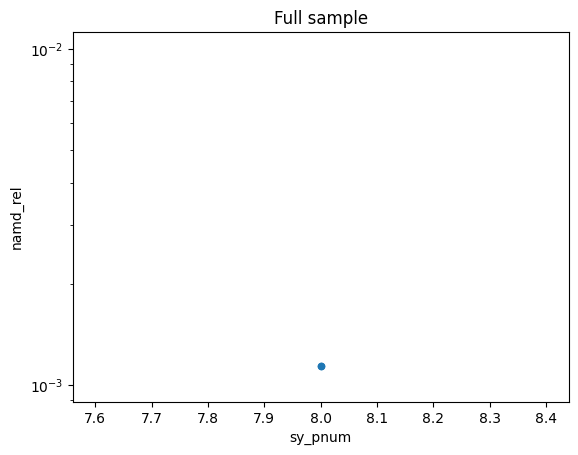

In [28]:
_ = (
    df.groupby("hostname")[["sy_pnum", "namd_rel"]]
    .mean()
    .reset_index()
    .plot(kind="scatter", x="sy_pnum", y="namd_rel", logy=True, title="Full sample")
)

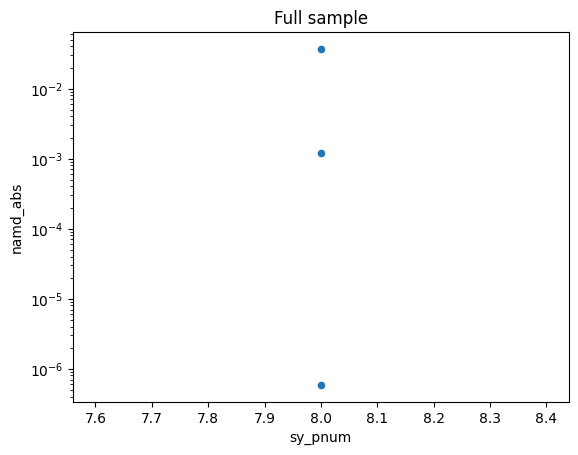

In [29]:
_ = (
    df.groupby("hostname")[["sy_pnum", "namd_abs"]]
    .mean()
    .reset_index()
    .plot(kind="scatter", x="sy_pnum", y="namd_abs", logy=True, title="Full sample")
)

### Task 9: computing the NAMD and associated confidence intervals


In [30]:
Npt = 200000
threshold = 1000

In [31]:
logger.info("Computing the Monte Carlo relative NAMD")
df = groupby_apply_merge(
    df,
    "hostname",
    solve_namd_mc,
    kind="rel",
    Npt=Npt,
    threshold=threshold,
    allow_overwrite=True,
)
logger.info("Relative NAMD computed")

2025-07-08 16:24:48.225 | INFO     | __main__:<module>:1 - Computing the Monte Carlo relative NAMD


2025-07-08 16:24:49.255 | INFO     | __main__:<module>:11 - Relative NAMD computed


In [32]:
logger.info("Computing the Monte Carlo absolute NAMD")
df = groupby_apply_merge(
    df,
    "hostname",
    solve_namd_mc,
    kind="abs",
    Npt=Npt,
    threshold=threshold,
    allow_overwrite=True,
)
logger.info("Absolute NAMD computed")

2025-07-08 16:24:50.115 | INFO     | __main__:<module>:1 - Computing the Monte Carlo absolute NAMD


2025-07-08 16:24:51.046 | INFO     | __main__:<module>:11 - Absolute NAMD computed


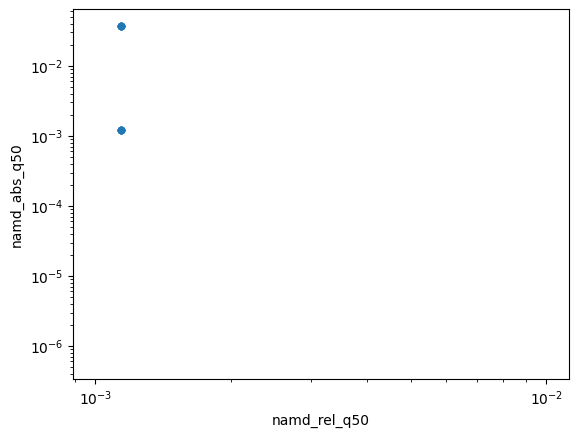

In [33]:
_ = (
    df.groupby("hostname")[["namd_rel_q50", "namd_abs_q50"]]
    .transform("mean")
    .plot(kind="scatter", x="namd_rel_q50", y="namd_abs_q50", loglog=True)
)

In [34]:
logger.info("Storing the NAMD database")
out_path = os.path.join(ROOT, "data", f"exo_namd_{fname}.csv")
df.to_csv(out_path, index=False)
logger.info(f"Database stored at {out_path}")

2025-07-08 16:25:34.698 | INFO     | __main__:<module>:1 - Storing the NAMD database
2025-07-08 16:25:34.708 | INFO     | __main__:<module>:4 - Database stored at /export/NAS/ariel/data/andrea.bocchieri/ExoNAMD/exonamd/data/exo_namd_custom_db_20241017e.csv


In [35]:
df = pd.read_csv(os.path.join(ROOT, "data", f"exo_namd_{fname}.csv"))

### Some plots


2025-07-08 16:25:39.625 | INFO     | __main__:<module>:1 - Plotting the NAMD vs. multiplicity


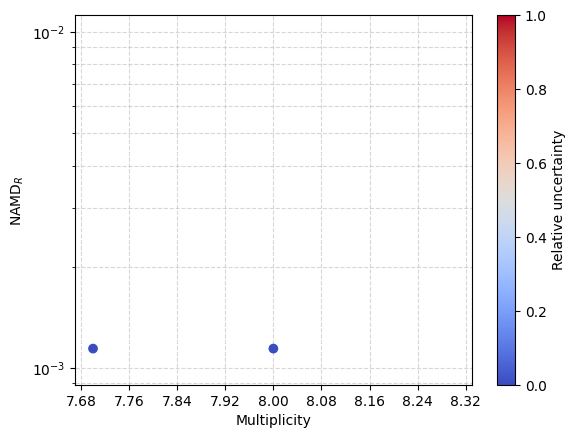

2025-07-08 16:25:39.943 | INFO     | __main__:<module>:12 - Plot done


In [36]:
logger.info("Plotting the NAMD vs. multiplicity")
pop_plot(
    df=df.groupby("hostname").apply(
        lambda g: g.select_dtypes(exclude=["object"]).mean(),
    ),
    kind="rel",
    # title="Core planets",
    which="namd",
    yscale="log",
    xoffs=True,
)
logger.info("Plot done")

2025-07-08 16:25:51.829 | INFO     | __main__:<module>:1 - Plotting the NAMD vs. multiplicity


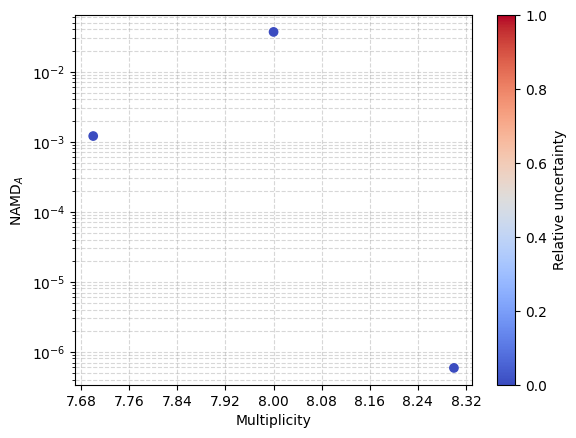

2025-07-08 16:25:52.271 | INFO     | __main__:<module>:12 - Plot done


In [37]:
logger.info("Plotting the NAMD vs. multiplicity")
pop_plot(
    df=df.groupby("hostname").apply(
        lambda g: g.select_dtypes(exclude=["object"]).mean(),
    ),
    kind="abs",
    # title="Core planets",
    which="namd",
    yscale="log",
    xoffs=True,
)
logger.info("Plot done")

In [38]:
# Npt = 10000000
# threshold = 1000

In [39]:
# plot_host_namd(
#     df=df,
#     hostname="TRAPPIST-1",
#     kind="abs",
#     Npt=Npt,
#     threshold=threshold,
# )

In [40]:
# plot_host_namd(
#     df=df,
#     hostname="Kepler-462",
#     kind="abs",
#     Npt=Npt,
#     threshold=threshold,
# )

TODO: 

1. check systems where the sy_pnum is different from the number of planets in the system reported in the exoplanet archive. e.g. XO-2 N
2. check compatibility with TepCat

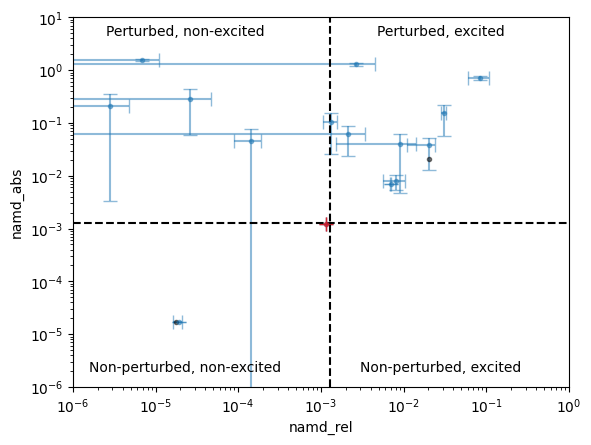

In [717]:
df_plot = df.groupby("hostname")[
    [
        "namd_rel",
        "namd_abs",
        "namd_rel_q16",
        "namd_rel_q50",
        "namd_rel_q84",
        "namd_abs_q16",
        "namd_abs_q50",
        "namd_abs_q84",
    ]
].apply(lambda g: g.select_dtypes(exclude=["object"]).mean())


import matplotlib.pyplot as plt

fig = plt.figure()

plt.yscale("log")
plt.xscale("log")
plt.xlabel("namd_rel")
plt.ylabel("namd_abs")

plt.errorbar(
    x=df_plot["namd_rel_q50"],
    y=df_plot["namd_abs_q50"],
    xerr=(
        df_plot["namd_rel_q84"] - df_plot["namd_rel_q50"],
        df_plot["namd_rel_q50"] - df_plot["namd_rel_q16"],
    ),
    yerr=(
        df_plot["namd_abs_q84"] - df_plot["namd_abs_q50"],
        df_plot["namd_abs_q50"] - df_plot["namd_abs_q16"],
    ),
    fmt="o",
    markersize=3,
    capsize=5,
    alpha=0.5,
)

SS = df_plot[df_plot.index == "SS"]

plt.errorbar(
    x=SS["namd_rel_q50"],
    y=SS["namd_abs_q50"],
    xerr=(
        SS["namd_rel_q84"] - SS["namd_rel_q50"],
        SS["namd_rel_q50"] - SS["namd_rel_q16"],
    ),
    yerr=(
        SS["namd_abs_q84"] - SS["namd_abs_q50"],
        SS["namd_abs_q50"] - SS["namd_abs_q16"],
    ),
    fmt="o",
    markersize=3,
    capsize=5,
    alpha=0.5,
    color="r",
)

missing_mc = df_plot[
    np.logical_or(df_plot["namd_abs_q50"].isna(), df_plot["namd_rel_q50"].isna())
]

plt.plot(
    missing_mc["namd_rel"],
    missing_mc["namd_abs"],
    "o",
    color="k",
    alpha=0.5,
    markersize=3,
)

ymin = 1e-6
ymax = 10
xmin = 1e-6
xmax = 1

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.vlines(1.3e-3, *plt.ylim(), colors=["k"], linestyles=["--"])
plt.hlines(1.3e-3, *plt.xlim(), colors=["k"], linestyles=["--"])

fig.text(0.3, 0.85, "Perturbed, non-excited", ha="center", va="center")
fig.text(0.7, 0.85, "Perturbed, excited", ha="center", va="center")

fig.text(0.3, 0.15, "Non-perturbed, non-excited", ha="center", va="center")
fig.text(0.7, 0.15, "Non-perturbed, excited", ha="center", va="center")

plt.show()

In [718]:
# df[["pl_name", "namd_rel", "namd_abs"]].values

In [720]:
# df[df["hostname"].isin(["TRAPPIST-1", "TOI-942"])].to_csv("deleteme.csv")

In [721]:
# df["hostname"].unique().size

In [722]:
# df_exo = pd.read_csv(
#     os.path.join('../exonamd', "data", "exo.csv"),
# )

# systems = ["TRAPPIST-1", "HD 110067", "55 Cnc", "KOI-351", "GJ 876"]
# df_exo = df_exo[df_exo["hostname"].isin(systems)]

# df_exo = df_exo[df_exo["default_flag"] == 1]

# # df_exo["pl_trueobliq"] = df_exo["pl_trueobliq"].fillna(np.random.uniform(0, 15))
# # df_exo["pl_orbeccen"] = df_exo["pl_orbeccen"].fillna(np.random.uniform(0, 0.15))
# # df_exo["pl_orbeccen"] = 0.0
# df_exo["pl_trueobliq"] = df_exo["pl_trueobliq"].fillna(np.random.uniform(0.005, 0.01))
# df_exo["pl_orbeccen"] = df_exo["pl_orbeccen"].fillna(np.random.uniform(0.005, 0.01))

# df_exo.to_csv(os.path.join('../exonamd', "data", "df_exo_famous.csv"), index=False)

# df_db = pd.read_csv(
#     os.path.join('../exonamd', "data", "custom_db_20241227.csv"),
# )

# df_db.loc[df_db["hostname"] == "TOI-942", "pl_orbeccen"] = 0.2
# df_db.loc[df_db["hostname"] == "TOI-942", "pl_orbeccenerr1"] = 0.1
# df_db.loc[df_db["hostname"] == "TOI-942", "pl_orbeccenerr2"] = -0.001

# df_new = pd.concat([df_db, df_exo])
# df_new.to_csv(os.path.join('../exonamd', "data", "custom_db_20241227_plus_famous.csv"), index=False)

# df_exo[["default_flag", "pl_name", "pl_bmasse", "pl_trueobliq", "pl_orbeccen"]].values

In [678]:
# df.loc[df["hostname"] == "TOI-942", "pl_orbeccenerr2"] = -0.01

In [719]:
# df.loc[df["hostname"] == "TOI-942", ["pl_bmasse", "pl_bmasseerr1", "pl_bmasseerr2"]]